In [169]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statistics

In [170]:
forecast_data = pd.read_csv("WWO_1LEADDAY_FORECAST.csv")
actual_data = pd.read_csv("ACTUAL_DATA.csv")

In [171]:
forecast_data = forecast_data.sort_values(['Location','Date'])

In [172]:
actual_data.columns = ['Date','Location','Precipitation']

We need to split these datasets into location based data values

In [173]:
actual_collection = {}
forecast_collection = {}

counter = 0

    
for location in forecast_data['Location'].unique():
    actual_collection[counter] = actual_data[actual_data['Location'] == location]
    forecast_collection[counter] = forecast_data[forecast_data['Location'] == location]
    
    counter = counter + 1

This is hourly data. We must change this to daily totals

In [174]:
def hourly_to_daily(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'],format="%Y-%m-%d %H:%M:%S")
    dataframe = dataframe.set_index('Date')
    dataframe = dataframe.resample('1d').sum()
            
    return dataframe

In [175]:
for i in range(0,len(actual_collection)):
    actual_collection[i] = hourly_to_daily(actual_collection[i])
    forecast_collection[i] = hourly_to_daily(forecast_collection[i])

<ipython-input-174-d4fb3b891d21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Date'] = pd.to_datetime(dataframe['Date'],format="%Y-%m-%d %H:%M:%S")


We have now imported our two datasets. The next step is to ensure that we only have data which is comparable to another set of data. This means removing entries from actual_data from which we do not have precipitation data

In [176]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [177]:
def comparison(actual,forecast):
    # Take the unique date values that appear in the indexes of both of these columns
    actual_date_values = actual.index.unique()
    forecast_date_values = forecast.index.unique()
    
    # Calculate the intersection of these values
    inter = intersection(actual_date_values,forecast_date_values)
    
    output_actual = actual[actual.index.isin(inter)]
    output_forecast = forecast[forecast.index.isin(inter)]
    
    return output_actual,output_forecast

In [178]:
for i in range(0,len(actual_collection)):
    actual_collection[i],forecast_collection[i] = comparison(actual_collection[i],forecast_collection[i])

Turn these into a list of inputs and outputs

In [179]:
X = []
y = []

for j in actual_collection:
    for i in range(0,len(actual_collection[j])):
        X.append(forecast_collection[j]['Precipitation'].iloc[i])
        y.append(actual_collection[j]['Precipitation'].iloc[i])

In [180]:
X[0:10]

[3.400000000000001,
 2.6000000000000005,
 5.9,
 0.0,
 0.1,
 0.1,
 10.899999999999999,
 1.7000000000000002,
 3.2999999999999994,
 1.1]

In [181]:
y[0:10]

[5.0,
 2.2,
 5.399999999999999,
 0.0,
 0.0,
 0.0,
 17.7,
 6.200000000000001,
 6.199999999999999,
 0.2]

We now have inputs and outputs

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [183]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

1594 786 1594 786


Building Linear Regression Model

In [184]:
from sklearn.linear_model import LinearRegression

In [185]:
model = LinearRegression()

In [186]:
model.fit(np.array(X_train).reshape(-1,1), y_train)

LinearRegression()

In [187]:
print(model.coef_)

[0.28120858]


In [188]:
print(model.intercept_)

2.8430433633861405


In [189]:
y_pred = model.predict(np.array(X_test).reshape(-1,1))

In [190]:
statistics.mean(y_test-y_pred)

-0.12113284010772951

In [191]:
statistics.mean(np.array(y_test)-np.array(X_test))

-0.03312128922815936

In [192]:
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,y_pred)))

Mean Squared Error: 22.61415157038979


In [193]:
print('R_squared Metric: {}'.format(r2_score(y_test,y_pred)))

R_squared Metric: 0.25394405637905193


Text(0.5, 1.0, ' Plot of Linear Regression Model ')

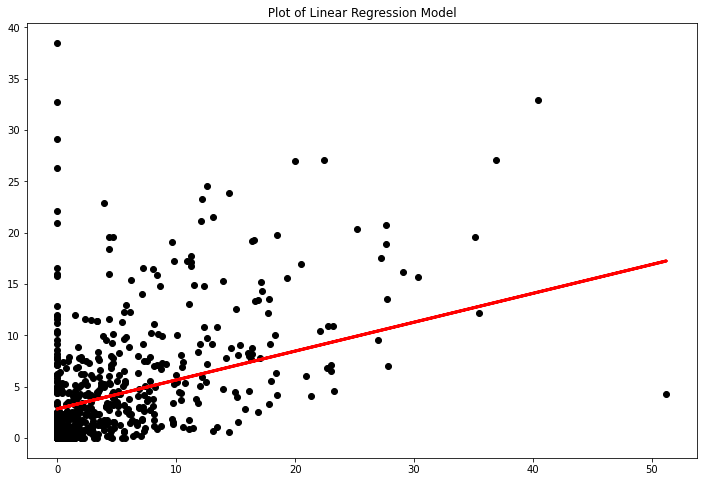

In [194]:
plt.figure(figsize=(12,8))
plt.scatter(X_test,y_test,color='black')
plt.plot(X_test,y_pred,color='red',linewidth=3)
plt.title(" Plot of Linear Regression Model ")

## Cross-Validation

In [195]:
from sklearn.model_selection import cross_validate

In [196]:
>>> scores = cross_validate(model, np.array(X).reshape(-1,1), y, cv=5,
...                         scoring=('r2', 'neg_root_mean_squared_error'),
...                         return_train_score=True)

In [197]:
statistics.mean(scores['test_r2'])

0.2143175504357216

# Multiple Simple Linear Regression Models

In [198]:
results_df = pd.DataFrame(columns = ['Forecast RMSE', 'Model RMSE'])

In [199]:
# Run 100 models
for i in range(0,10000):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)
    
    m_model = LinearRegression()
    m_model.fit(np.array(X_train).reshape(-1,1), y_train)
    
    y_pred = m_model.predict(np.array(X_test).reshape(-1,1))
    
    results_df = results_df.append({'Forecast RMSE':np.sqrt(statistics.mean((np.array(y_test)-np.array(X_test))**2)),'Model RMSE':np.sqrt(statistics.mean((np.array(y_test)-np.array(y_pred))**2))},ignore_index=True)

In [200]:
results_df.mean()

Forecast RMSE    7.143071
Model RMSE       4.906573
dtype: float64

In [201]:
results_df

,Forecast RMSE,Model RMSE
0,8.949171,5.373383
1,5.271290,4.664338
2,8.518991,4.685916
3,6.547426,4.179713
4,6.010781,5.049262
...,...,...
9995,5.985708,4.063772
9996,6.474124,4.762115
9997,5.345001,4.499651
9998,8.818757,4.790881


# Neural Network

In [202]:
from sklearn.neural_network import MLPRegressor

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    random_state=1)

In [204]:
regr = MLPRegressor(random_state=1, max_iter=5000).fit(np.array(X_train).reshape(-1,1), y_train)

In [205]:
y_pred = regr.predict(np.array(X_test).reshape(-1,1))

In [206]:
results_df2 = pd.DataFrame(columns = ['Forecast RMSE', 'Model RMSE'])

In [207]:
# Run 100 models
for i in range(0,1000):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)
    
    regr = MLPRegressor(random_state=1, max_iter=500).fit(np.array(X_train).reshape(-1,1), y_train)
    m_model.fit(np.array(X_train).reshape(-1,1), y_train)
    
    y_pred = regr.predict(np.array(X_test).reshape(-1,1))
    
    results_df2 = results_df2.append({'Forecast RMSE':np.sqrt(statistics.mean((np.array(y_test)-np.array(X_test))**2)),'Model RMSE':np.sqrt(statistics.mean((np.array(y_test)-np.array(y_pred))**2))},ignore_index=True)

C:\Users\u\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [208]:
results_df2.mean()

Forecast RMSE    7.158332
Model RMSE       4.641725
dtype: float64